In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import os
from typing import Optional, Union, Tuple, List
import gym
import gym.envs.registration
import gym.spaces
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import plotly.express as px
import plotly.graph_objects as go
import utils

Arr = np.ndarray

MAIN = __name__ == "__main__"
max_episode_steps = 1000
IS_CI = os.getenv("IS_CI")
N_RUNS = 200 if not IS_CI else 5

in utils.py why are solutions imported twice? from w3d5_chapter4_tabular import solutions

In [3]:
class Environment:
    def __init__(self, num_states: int, num_actions: int, start=0, terminal=None):
        self.num_states = num_states
        self.num_actions = num_actions
        self.start = start
        self.terminal = np.array([], dtype=int) if terminal is None else terminal
        (self.T, self.R) = self.build()

    def build(self):
        '''
        Constructs the T and R tensors from the dynamics of the environment.
        Outputs:
            T : (num_states, num_actions, num_states) State transition probabilities
            R : (num_states, num_actions, num_states) Reward function
        '''
        num_states = self.num_states
        num_actions = self.num_actions
        T = np.zeros((num_states, num_actions, num_states))
        R = np.zeros((num_states, num_actions, num_states))
        for s in range(num_states):
            for a in range(num_actions):
                (states, rewards, probs) = self.dynamics(s, a)
                (all_s, all_r, all_p) = self.out_pad(states, rewards, probs)
                T[s, a, all_s] = all_p
                R[s, a, all_s] = all_r
        return (T, R)

    def dynamics(self, state: int, action: int) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        '''
        Computes the distribution over possible outcomes for a given state
        and action.
        Inputs:
            state : int (index of state)
            action : int (index of action)
        Outputs:
            states  : (m,) all the possible next states
            rewards : (m,) rewards for each next state transition
            probs   : (m,) likelihood of each state-reward pair
        '''
        raise NotImplementedError

    def render(pi: np.ndarray):
        '''
        Takes a policy pi, and draws an image of the behavior of that policy, if applicable.
        Inputs:
            pi : (num_actions,) a policy
        Outputs:
            None
        '''
        raise NotImplementedError

    def out_pad(self, states: np.ndarray, rewards: np.ndarray, probs: np.ndarray):
        '''
        Inputs:
            states  : (m,) all the possible next states
            rewards : (m,) rewards for each next state transition
            probs   : (m,) likelihood of each state-reward pair
        Outputs:
            states  : (num_states,) all the next states
            rewards : (num_states,) rewards for each next state transition
            probs   : (num_states,) likelihood of each state-reward pair (including zero-prob outcomes.)
        '''
        out_s = np.arange(self.num_states)
        out_r = np.zeros(self.num_states)
        out_p = np.zeros(self.num_states)
        for i in range(len(states)):
            idx = states[i]
            out_r[idx] += rewards[i]
            out_p[idx] += probs[i]
        return (out_s, out_r, out_p)

In [4]:
class Toy(Environment):
    def dynamics(self, state: int, action: int):
        (S0, SL, SR) = (0, 1, 2)
        LEFT = 0
        num_states = 3
        num_actions = 2
        assert 0 <= state < self.num_states and 0 <= action < self.num_actions
        if state == S0:
            if action == LEFT:
                (next_state, reward) = (SL, 1)
            else:
                (next_state, reward) = (SR, 0)
        elif state == SL:
            (next_state, reward) = (S0, 0)
        elif state == SR:
            (next_state, reward) = (S0, 2)
        return (np.array([next_state]), np.array([reward]), np.array([1]))

    def __init__(self):
        super().__init__(3, 2)

In [5]:
if MAIN:
    toy = Toy()
    print(toy.T)
    print(toy.R)

[[[0. 1. 0.]
  [0. 0. 1.]]

 [[1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]]]
[[[0. 1. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]]

 [[2. 0. 0.]
  [2. 0. 0.]]]


In [6]:
class Norvig(Environment):
    def dynamics(self, state: int, action: int) -> tuple[Arr, Arr, Arr]:
        def state_index(state):
            assert 0 <= state[0] < self.width and 0 <= state[1] < self.height, print(state)
            pos = state[0] + state[1] * self.width
            assert 0 <= pos < self.num_states, print(state, pos)
            return pos

        pos = self.states[state]
        move = self.actions[action]
        if state in self.terminal or state in self.walls:
            return (np.array([state]), np.array([0]), np.array([1]))
        out_probs = np.zeros(self.num_actions) + 0.1
        out_probs[action] = 0.7
        out_states = np.zeros(self.num_actions, dtype=int) + self.num_actions
        out_rewards = np.zeros(self.num_actions) + self.penalty
        new_states = [pos + x for x in self.actions]
        for (i, s_new) in enumerate(new_states):
            if not (0 <= s_new[0] < self.width and 0 <= s_new[1] < self.height):
                out_states[i] = state
                continue
            new_state = state_index(s_new)
            if new_state in self.walls:
                out_states[i] = state
            else:
                out_states[i] = new_state
            for idx in range(len(self.terminal)):
                if new_state == self.terminal[idx]:
                    out_rewards[i] = self.goal_rewards[idx]
        return (out_states, out_rewards, out_probs)

    def render(self, pi: Arr):
        assert len(pi) == self.num_states
        emoji = ["⬆️", "➡️", "⬇️", "⬅️"]
        grid = [emoji[act] for act in pi]
        grid[3] = "🟩"
        grid[7] = "🟥"
        grid[5] = "⬛"
        print(str(grid[0:4]) + "\n" + str(grid[4:8]) + "\n" + str(grid[8:]))

    def __init__(self, penalty=-0.04):
        self.height = 3
        self.width = 4
        self.penalty = penalty
        num_states = self.height * self.width
        num_actions = 4
        self.states = np.array([[x, y] for y in range(self.height) for x in range(self.width)])
        self.actions = np.array([[0, -1], [1, 0], [0, 1], [-1, 0]])
        self.dim = (self.height, self.width)
        terminal = np.array([3, 7], dtype=int)
        self.walls = np.array([5], dtype=int)
        self.goal_rewards = np.array([1.0, -1])
        super().__init__(num_states, num_actions, start=8, terminal=terminal)

In [7]:
def policy_eval_numerical(env: Environment, pi: Arr, gamma=0.99, eps=1e-08) -> Arr:
    '''
    Numerically evaluates the value of a given policy by iterating the Bellman equation
    Inputs:
        env: Environment
        pi : shape (num_states,) - The policy to evaluate
        gamma: float - Discount factor
        eps  : float - Tolerance
    Outputs:
        value : float (num_states,) - The value function for policy pi
    '''
    T = env.T
    R = env.R
    num_states = env.num_states
    V = np.zeros(num_states)

    for i in range(1000):
        for state in range(num_states):
            action = pi[state]
            transition_vector = T[state, action]
            reward_vector = R[state, action] + gamma*V  # V from the previous iteration is used as the approximation of the value function
            V[state] = transition_vector.T @ reward_vector
    return V


norvig = Norvig()
pi = np.random.randint(norvig.num_actions, size=(norvig.num_states,))
policy_eval_numerical(env=norvig, pi=pi)
if MAIN:
    utils.test_policy_eval(policy_eval_numerical, exact=False)

In [8]:
def policy_eval_exact(env: Environment, pi: Arr, gamma=0.99) -> Arr:
    """
    Returns the value function for policy and env
    Inputs:
        env: Environment
        pi : shape (num_states,) - The policy to evaluate
        gamma: float - Discount factor
    Outputs:
        value : float (num_states,) - The value function for policy pi
    """
    T = env.T
    R = env.R
    num_states = env.num_states
    V = np.zeros(num_states)

    # Both of these are (num_states, num_states) matrices. 
    # P_pi = T(j|pi(i), i) for states i and j
    # P_pi = T[:, ]
    # reward for states given action 
    # R_pi = R[:, ]

    idx = np.arange(num_states)
    P_pi = T[idx, pi[idx]]
    R_pi = R[idx, pi[idx]]

    r = np.einsum("ij,ij -> i", P_pi, R_pi) 

    v = np.linalg.inv(np.eye(num_states) - gamma*P_pi) @ r
    return v

    
norvig = Norvig()
pi = np.random.randint(norvig.num_actions, size=(norvig.num_states,))
v = policy_eval_exact(env=norvig, pi=pi)

if MAIN:
    utils.test_policy_eval(policy_eval_exact, exact=True)

In [9]:
def policy_improvement(env: Environment, V: Arr, gamma=0.99) -> Arr:
    '''
    Inputs:
        env: Environment
        V  : (num_states,) value of each state following some policy pi
    Outputs:
        pi_better : vector (num_states,) of actions representing a new policy obtained via policy iteration
    '''
    num_states = env.num_states
    pi = np.random.randint(low=0, high=num_states, size=num_states)
    T = env.T
    R = env.R

    # reward plus value function
    Q = R + V
    better_policy = np.argmax(np.einsum("abc,abc-> ab", T, Q), axis=1)

    return better_policy



policy_improvement(env=norvig, V=v)

if MAIN:
    utils.test_policy_improvement(policy_improvement)

In [10]:
def find_optimal_policy(env: Environment, gamma=0.99):
    '''
    Inputs:
        env: environment
    Outputs:
        pi : (num_states,) int, of actions represeting an optimal policy
    '''
    num_states, num_actions = env.num_states, env.num_actions
    pi = np.random.randint(low=0, high=num_actions, size=num_states)
    V = policy_eval_exact(env, pi, gamma=gamma)
    better_pi = policy_improvement(env, V, gamma=gamma)

    while np.any(pi != better_pi):
        pi = np.copy(better_pi)
        V = policy_eval_exact(env, pi, gamma=gamma)
        better_pi = policy_improvement(env, V, gamma=gamma)
    
    return better_pi

if MAIN:
    utils.test_find_optimal_policy(find_optimal_policy)
    penalty = -0.04
    norvig = Norvig(penalty)
    pi_opt = find_optimal_policy(norvig, gamma=0.99)
    norvig.render(pi_opt)

['➡️', '➡️', '➡️', '🟩']
['⬆️', '⬛', '⬆️', '🟥']
['⬆️', '⬅️', '⬆️', '⬅️']


# Q-learning and DQN

What is Temporal Difference learning?

In comparison to Monte Carlo methods, TD can update $V_\pi$ at every timestep. Monte Carlo methods have to wait until the end of the episode.

In [11]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from dataclasses import dataclass
from typing import Optional, Union, List
import numpy as np
import gym
import gym.spaces
import gym.envs.registration
from gym.utils import seeding
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from PIL import Image, ImageDraw

import utils

MAIN = __name__ == "__main__"

What is the difference between an observation and a state?

An observation is less complete than the state.

In [12]:
ObsType = int
ActType = int

class DiscreteEnviroGym(gym.Env):
    action_space: gym.spaces.Discrete
    observation_space: gym.spaces.Discrete

    def __init__(self, env: Environment):
        super().__init__()
        self.env = env
        self.observation_space = gym.spaces.Discrete(env.num_states)
        self.action_space = gym.spaces.Discrete(env.num_actions)
        self.reset()

    def step(self, action: ActType) -> tuple[ObsType, float, bool, dict]:
        '''
        Samples from the underlying dynamics of the environment
        '''
        (states, rewards, probs) = self.env.dynamics(self.pos, action)
        idx = self.np_random.choice(len(states), p=probs)
        (new_state, reward) = (states[idx], rewards[idx])
        self.pos = new_state
        done = self.pos in self.env.terminal
        truncated = False
        return (new_state, reward, done, truncated, {"env": self.env})

    def reset(
        self, seed: Optional[int] = None, return_info=False, options=None
    ) -> Union[ObsType, tuple[ObsType, dict]]:
        super().reset(seed=seed)
        self.pos = self.env.start
        return (self.pos, {"env": self.env}) if return_info else self.pos

    def render(self, mode="human"):
        assert mode == "human", f"Mode {mode} not supported!"

In [13]:
gym.envs.registration.register(
    id="NorvigGrid-v0",
    entry_point=DiscreteEnviroGym,
    max_episode_steps=100,
    nondeterministic=True,
    kwargs={"env": Norvig(penalty=-0.04)},
)

gym.envs.registration.register(
    id="ToyGym-v0", 
    entry_point=DiscreteEnviroGym, 
    max_episode_steps=2, 
    nondeterministic=False, 
    kwargs={"env": Toy()}
)

In [14]:
@dataclass
class Experience:
    '''A class for storing one piece of experience during an episode run'''
    obs: ObsType
    act: ActType
    reward: float
    new_obs: ObsType
    new_act: Optional[ActType] = None

@dataclass
class AgentConfig:
    '''Hyperparameters for agents'''
    epsilon: float = 0.1
    lr: float = 0.05
    optimism: float = 0

defaultConfig = AgentConfig()

class Agent:
    '''Base class for agents interacting with an environment (you do not need to add any implementation here)'''
    rng: np.random.Generator

    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma: float = 0.99, seed: int = 0):
        self.env = env
        self.reset(seed)
        self.config = config
        self.gamma = gamma
        self.num_actions = env.action_space.n
        self.num_states = env.observation_space.n
        self.name = type(self).__name__

    def get_action(self, obs: ObsType) -> ActType:
        raise NotImplementedError()

    def observe(self, exp: Experience) -> None:
        '''
        Agent observes experience, and updates model as appropriate.
        Implementation depends on type of agent.
        '''
        pass

    def reset(self, seed: int) -> None:
        self.rng = np.random.default_rng(seed)

    def run_episode(self, seed) -> List[int]:
        '''
        Simulates one episode of interaction, agent learns as appropriate
        Inputs:
            seed : Seed for the random number generator
        Outputs:
            The rewards obtained during the episode
        '''
        rewards = []
        obs = self.env.reset(seed=seed)
        self.reset(seed=seed)
        done = False
        while not done:
            act = self.get_action(obs)
            (new_obs, reward, done, truncated, info) = self.env.step(act)
            done = done or truncated
            exp = Experience(obs, act, reward, new_obs)
            self.observe(exp)
            rewards.append(reward)
            obs = new_obs
        return rewards

    def train(self, n_runs=500):
        '''
        Run a batch of episodes, and return the total reward obtained per episode
        Inputs:
            n_runs : The number of episodes to simulate
        Outputs:
            The discounted sum of rewards obtained for each episode
        '''
        all_rewards = []
        for seed in trange(n_runs):
            rewards = self.run_episode(seed)
            all_rewards.append(utils.sum_rewards(rewards, self.gamma))
        return all_rewards

class Random(Agent):
    def get_action(self, obs: ObsType) -> ActType:
        return self.rng.integers(0, self.num_actions)

  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\simon\.conda\envs\science\lib\site-packages\gym\utils\passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'int'>`
  logger.warn(
c:\Users\simon\.conda\envs\science\lib\site-packages\gym\utils\passive_env_checker.py:133: UserWarning: WARN: The obs returned by the `step()` method should be an int or np.int64, actual type: <class 'numpy.int32'>
  logger.warn(f"{pre} should be an int or np.int64, actual type: {type(obs)}")
100%|██████████| 100/100 [00:00<00:00, 6405.86it/s]


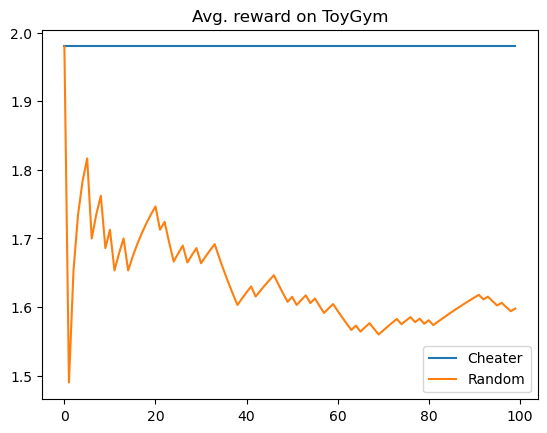

In [17]:
class Cheater(Agent):
    def __init__(self, env: DiscreteEnviroGym, config: AgentConfig = defaultConfig, gamma=0.99, seed=0):
        super().__init__(env=env, config=config, gamma=gamma, seed=seed)
        
        self.optimal_policy = find_optimal_policy(self.env.unwrapped.env)

    def get_action(self, obs):
        return self.optimal_policy[obs]


if MAIN:
    env_toy = gym.make("ToyGym-v0")
    agents_toy = [Cheater(env_toy), Random(env_toy)]
    for agent in agents_toy:
        returns = agent.train(n_runs=100)
        plt.plot(utils.cummean(returns), label=agent.name)
    plt.legend()
    plt.title(f"Avg. reward on {env_toy.spec.name}")
    plt.show()